В качестве датасета был выбран World Bank.

In [1]:
import pandas as pd, requests, zipfile, io, re
from sqlalchemy import create_engine, text
import seaborn as sns
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv

In [2]:
# Прямая ссылка на CSV-архив WDI
url = "https://databank.worldbank.org/data/download/WDI_CSV.zip"

r = requests.get(url, timeout=120)
z = zipfile.ZipFile(io.BytesIO(r.content))

df_data = pd.read_csv(z.open("WDICSV.csv"), low_memory=False)
df_country = pd.read_csv(z.open("WDICountry.csv"), low_memory=False)
df_series = pd.read_csv(z.open("WDISeries.csv"), low_memory=False)

# Основные данные
year_cols = [c for c in df_data.columns if re.fullmatch(r"\d{4}", str(c))] # Определим колонки с годами
df_data = df_data.melt(
    id_vars=["Country Name", "Country Code", "Indicator Name", "Indicator Code"],
    value_vars=year_cols,
    var_name="year",
    value_name="value"
) # Преобразуем wide → long
df_data["year"] = df_data["year"].astype(int) # Приведём типы
df_data.rename(columns={
    "Country Name": "country",
    "Country Code": "country_id",
    "Indicator Name": "series",
    "Indicator Code": "series_id"
}, inplace=True)

# Страны
df_country.rename(columns={
    "Country Code": "id",
    "Table Name": "country",
    "Region": "region",
    "Income Group": "income_group"
}, inplace=True)

# Индикаторы
df_series.rename(columns={
    "Series Code": "id",
    "Indicator Name": "series",
    "Topic": "topic",
    "Unit of measure": "unit"
}, inplace=True)

In [3]:
# Загружаем .env
load_dotenv(override=True)

# параметры подключения
user = os.getenv("PGUSER")
password = os.getenv("PGPASSWORD")
host = os.getenv("PGHOST")
port = os.getenv("PGPORT")
db = os.getenv("PGDATABASE")

engine = create_engine(f"postgresql://{user}:{password}@{host}:{port}/{db}")

In [4]:
def copy_from_df(df, table_name, engine):
    """
    Быстрая загрузка DataFrame в PostgreSQL через COPY.
    """
    df.head(0).to_sql(f"{table_name}", engine, if_exists="replace", index=False)

    with engine.begin() as conn:
        conn.execute(text(f"TRUNCATE {table_name};"))
    
    buf = io.StringIO()
    df.to_csv(buf, index=False, header=True)
    buf.seek(0)

    conn = engine.raw_connection()
    try:
        cur = conn.cursor()
        cur.copy_expert(f"COPY {table_name} FROM STDIN WITH CSV HEADER", buf)
        conn.commit()
    finally:
        conn.close()

# Страны
copy_from_df(df_country, "wb_country", engine)

# Индикаторы
copy_from_df(df_series, "wb_series", engine)

# Основные данные
copy_from_df(df_data, "wb_data", engine)

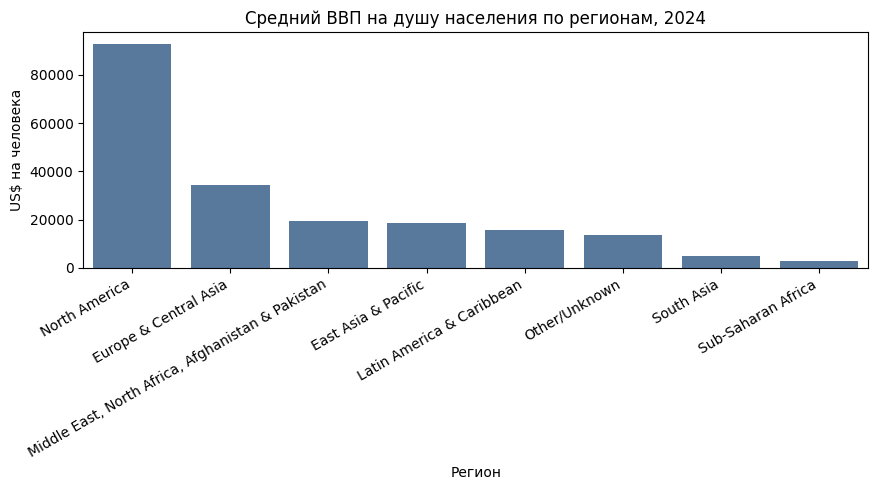

In [5]:
# Средний ВВП на душу по регионам (2024)

q = """
SELECT COALESCE(c.region, 'Other/Unknown') as region, 
    AVG(d.value) AS avg_gdp_per_capita_2024
FROM wb_data d
JOIN wb_country c ON c.id = d.country_id
JOIN wb_series s ON s.id = d.series_id
WHERE s.id = 'NY.GDP.PCAP.CD' AND d.year = 2024
GROUP BY c.region
ORDER BY avg_gdp_per_capita_2024 DESC;
"""
df_gdp = pd.read_sql(q, engine)

plt.figure(figsize=(9,5))
sns.barplot(data=df_gdp, x="region", y="avg_gdp_per_capita_2024", color="#4C78A8")
plt.title("Средний ВВП на душу населения по регионам, 2024")
plt.xlabel("Регион")
plt.ylabel("US$ на человека")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

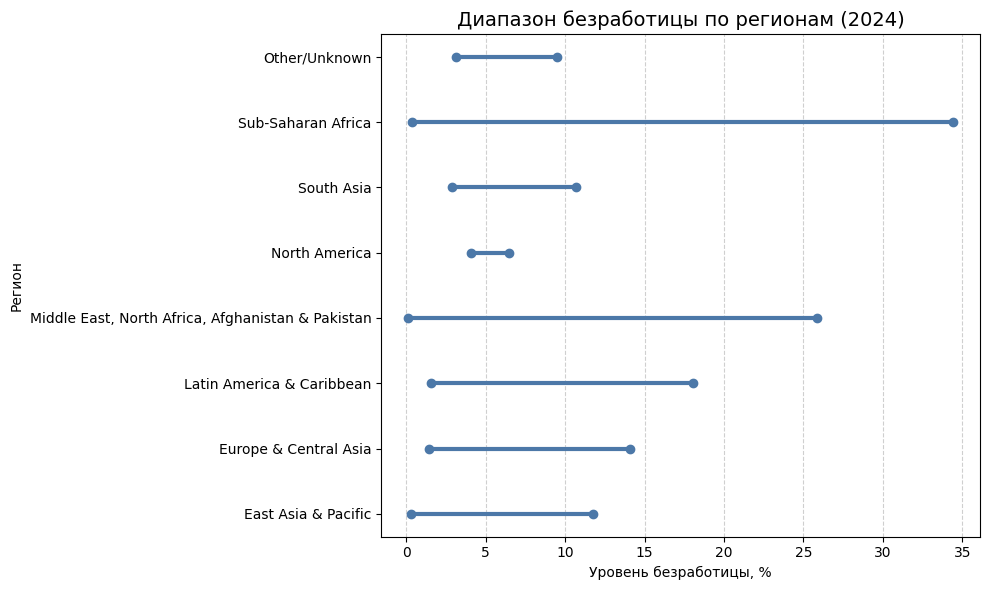

In [6]:
# Минимальный и максимальный уровень безработицы по регионам

q = """
SELECT COALESCE(c.region, 'Other/Unknown') as region,
       MIN(d.value) AS min_unemployment,
       MAX(d.value) AS max_unemployment
FROM wb_data d
JOIN wb_country c ON c.id = d.country_id
JOIN wb_series s ON s.id = d.series_id
WHERE s.id = 'SL.UEM.TOTL.ZS'
  AND d.year = 2024
GROUP BY c.region
ORDER BY c.region;
"""

df = pd.read_sql(q, engine)

# Построим график: диапазон min–max по регионам
plt.figure(figsize=(10,6))
for i, row in df.iterrows():
    plt.plot([row['min_unemployment'], row['max_unemployment']], [row['region'], row['region']], 
             marker='o', color="#4C78A8", linewidth=3)

plt.title("Диапазон безработицы по регионам (2024)", fontsize=14)
plt.xlabel("Уровень безработицы, %")
plt.ylabel("Регион")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

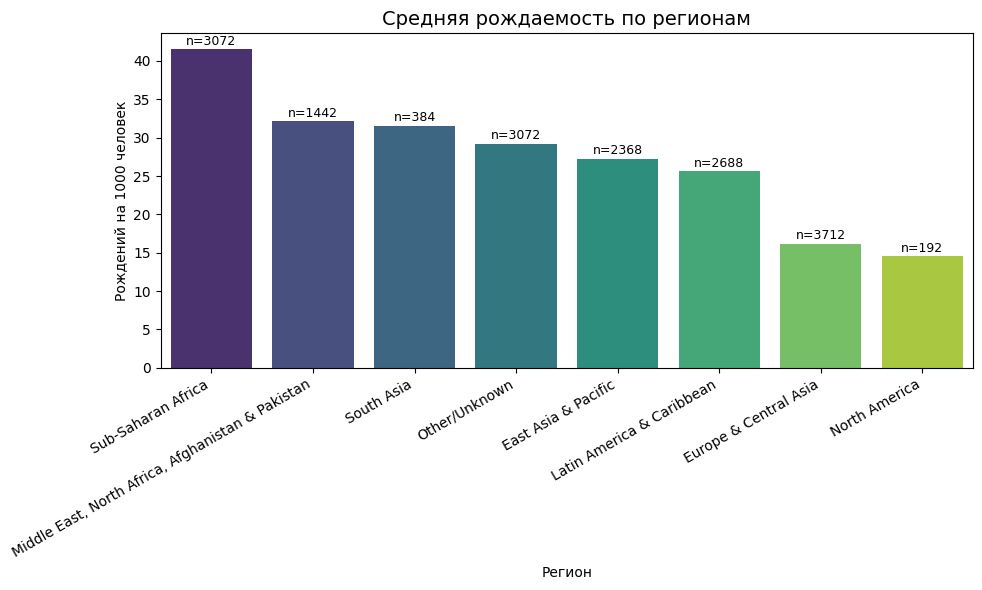

In [7]:
# Средняя рождаемость и количество наблюдений по регионам

q = """
SELECT COALESCE(c.region, 'Other/Unknown') as region,
       COUNT(d.value) AS records_count,
       AVG(d.value) AS avg_birth_rate
FROM wb_data d
JOIN wb_country c ON c.id = d.country_id
JOIN wb_series s ON s.id = d.series_id
WHERE s.id = 'SP.DYN.CBRT.IN'
GROUP BY c.region
ORDER BY avg_birth_rate DESC;
"""

df = pd.read_sql(q, engine)

# Столбчатая диаграмма: средняя рождаемость по регионам
plt.figure(figsize=(10,6))
sns.barplot(data=df, x="region", y="avg_birth_rate", hue="region", palette="viridis", legend=False)

# Добавим подписи с количеством записей
for i, row in df.iterrows():
    plt.text(i, row["avg_birth_rate"] + 0.2, f"n={row['records_count']}", 
             ha="center", va="bottom", fontsize=9, color="black")

plt.title("Средняя рождаемость по регионам", fontsize=14)
plt.xlabel("Регион")
plt.ylabel("Рождений на 1000 человек")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()